In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import gridspec
import matplotlib.colors as colors
from os import listdir, mkdir
from os.path import isfile, sep
from glob import glob
from scipy.interpolate import interp1d

import seaborn as sns
sns.set_style('ticks')

from sys import path

# import basic data processing function
path.insert(1, '/Users/hannah/Dropbox/code/flyVR/utilities/')
from loadSingleTrial import loadSingleVRLogfile
from loadObjectCoords import loadObjectCoordIdentities

path.insert(1, '/Users/hannah/Dropbox/code/trajectoryAnalysis/')
from downsample import donwsampleFOData
from trajectoryDerivedParams import convertRawHeadingAngle, velocityFromTrajectory, relationToObject,\
    cartesian2polar, polarCurvature
from periodicWorldAnalysis import collapseToMiniArena, collapseTwoObjGrid

# import custom plotting functions
path.insert(1, '/Users/hannah/Dropbox/code/plottingUtilities/')
from plottingUtilities import myAxisTheme, timeAxisTheme, niceScatterPlot, makeNestedPlotDirectory
from flyTracePlots import plotPosInRange, plotFlyVRtimeStp, plotPolarTrace
from velocityDistributionPlots import plotVeloHistogram_fancy, velocitySummaryPlot

%matplotlib inline

In [233]:
import os
os.environ

{'DESTINATION': '/var/folders/5d/08jnsv0x0x1g6pzpvf5744kh0000gp/T/iTerm 2.1.4 Update', 'LOGNAME': 'hannah', 'USER': 'hannah', 'HOME': '/Users/hannah', 'PATH': '/Users/hannah/anaconda/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/opt/X11/bin:/usr/local/git/bin:/usr/texbin:/Applications/CMake.app/Contents/bin', 'DISPLAY': '/private/tmp/com.apple.launchd.Qq8JnZldiK/org.macosforge.xquartz:0', 'TERM_PROGRAM': 'iTerm.app', 'LANG': 'en_GB.UTF-8', 'TERM': 'xterm-color', 'Apple_PubSub_Socket_Render': '/private/tmp/com.apple.launchd.m2M2F2CsB0/Render', 'COLORFGBG': '7;0', 'SHLVL': '2', 'SECURITYSESSIONID': '186a5', 'XPC_FLAGS': '0x0', 'ITERM_SESSION_ID': 'w0t4p0', '_': '/Users/hannah/anaconda/python.app/Contents/MacOS/python', 'SSH_AUTH_SOCK': '/private/tmp/com.apple.launchd.BFhzHh0ydy/Listeners', 'JPY_PARENT_PID': '21721', 'XPC_SERVICE_NAME': '0', 'SHELL': '/bin/bash', 'GIT_PAGER': 'cat', 'ITERM_PROFILE': 'Default', 'TMPDIR': '/var/folders/5d/08jnsv0x0x1g6pzpvf5744kh0000gp/T/', 'PYTHONEXECU

### Load raw data
#### Choose files to analyse

In [185]:
dataDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObject/FlyOver095_lowContrast/stripetracking/WTB/males/'
flyID = 'm06'
expDir = dataDir + 'rawData/' + flyID + sep
FODataFiles = listdir(expDir)

try:
    
    mkdir(dataDir + 'analysis/')
except OSError:
    print('Analysis directory already exists.')

FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
FODataFiles = sorted(FODataFiles)
FODataFiles

Analysis directory already exists.


['singleObjectForest_1cm4cmCone_12cmHex_WTB_m06_out_160611155118.txt',
 'singleObjectForest_1cm4cmCone_12cmHex_inverted_WTB_m06_out_160611160227.txt',
 'stripe_BlackOnWhite_WTB_m06_out_160611154009.txt',
 'stripe_Whiteonblack_WTB_m06_out_160611152905.txt']

In [216]:
# choose experiment
trial = 3

FODataFile = FODataFiles[trial-1]
print(FODataFile)

dataFileParts = FODataFile.split('_')
genotype = dataFileParts[2]
sceneName = dataFileParts[0]
titleString = 'fly '+flyID+' ('+genotype+')'+' in '+sceneName+' world'

if ('Stripe' in sceneName or 'stripe' in sceneName):
    sceneType = 'stripe'
else:
    sceneType = 'plane'

print(titleString)

print('scene type: ' + sceneType)

stripe_BlackOnWhite_WTB_m06_out_160611154009.txt
fly m06 (WTB) in stripe world
scene type: stripe


### Load data

#### Load FlyOver log file, extract calibration paramater and name of cood file

In [217]:
header, FOData, numFrames, frameRange, calibParams, coordFile = loadSingleVRLogfile(expDir, FODataFile)

#### Read in object coordinates

In [218]:
visObjCoords, visObjName, invisObjCoords, origin = loadObjectCoordIdentities(dataDir, coordFile)

### Compute derrived values

#### Compute movement velocities

In [219]:
logTime = np.copy(FOData[:, 0])
time = np.linspace(0, logTime[-1], numFrames)

angle = convertRawHeadingAngle(FOData[:, 5])

#### Collapse to 'mini-arena' while preserving the global heading  ---  if trialtype is 'plane'

In [220]:
if sceneType=='plane':
    xPos = FOData[:, 1]
    yPos = FOData[:, 2]
    arenaRad = 60 # 1/2 distance between objects
    objectCoords = np.copy(visObjCoords[0:-3, 0:2])

    xPosMA, yPosMA = collapseToMiniArena(xPos, yPos, arenaRad, objectCoords)

#### Compute fly's walking velocieties from TM raw values  ---  if trial type is 'stripe'

In [221]:
if sceneType=='stripe':
    dx1 = FOData[:,6]
    dy1 = FOData[:,7]
    dx2 = FOData[:,8]
    dy2 = FOData[:,9]
    
    dtime = np.diff(time)
    dtime = np.hstack((dtime[0],dtime))
    
    # parameter definitions
    gammaRad = 45*np.pi/180; #absolute angle of cameras to longitudinal axis (of fly)
    rBall = float(calibParams[0])
    pixel2mm = 0.013514

    conversionFactor_pitch = (1.0/pixel2mm)*float(calibParams[0])*2.0*(np.pi/2.0)*(1.0/float(calibParams[1]))
    conversionFactor_yaw = (1.0/pixel2mm)*float(calibParams[0])*2.0*(np.pi/2.0)*(1.0/float(calibParams[2]))

    # compute virtual rotation of fly
    vFwdBall = - (dy1 + dy2) * np.cos(gammaRad); #add components along longitudinal axis
    vSideBall = - (dy1 - dy2) * np.sin(gammaRad); #add components along transversal axis
    vRotBall = - (dx1 + dx2)/2 #average measured displacement along aximuth

    # convert A.U. --> pixel --> mm
    vFwdBall = pixel2mm * vFwdBall * conversionFactor_pitch # use scaling factor for pitch
    vSideBall = pixel2mm * vSideBall * ((conversionFactor_yaw + conversionFactor_pitch)/2) #use mean
    vRotBall = pixel2mm * vRotBall * conversionFactor_yaw # use scaling factor for yaw

    # convert to mm/s
    vFwdBall = vFwdBall / dtime
    vSideBall = vSideBall / dtime
    vRotBall =  vRotBall / dtime

    vRot = - vRotBall / rBall #mm/s to deg/s

    # Assume initial position (0 0 0) = (x-coord, y-coord, angle): 
    # --> fly in origin, aligned with x axis (head forward)
    # During measurement coordinate system is fly-centered, moves with fly.
    # Compute all changes along those axes by updating angle and
    # projecting the position changes onto the fixed coordinate system

    angle = np.cumsum(vRot * dtime)
    angle = np.mod((angle + np.pi),2*np.pi) - np.pi

    # movement in x and y direction
    yTM_i = vSideBall * np.cos(-angle) - vFwdBall * np.sin(-angle) #compute increments x_i
    yPos = np.cumsum(yTM_i* dtime) # integrate x_i to get path

    xTM_i = vSideBall * np.sin(-angle) + vFwdBall * np.cos(-angle)
    xPos = np.cumsum(xTM_i * dtime)

    vTrans = np.hypot(xTM_i, yTM_i)

#### Downsample

In [222]:
# Down sample data to 20 Hz ........................................................................................
samplingRate = 20
time_ds, xPos_ds, yPos_ds, angle_ds, numFrames_ds \
    = donwsampleFOData(samplingRate, logTime, time, xPos, yPos, angle)

# and compute downsampled velocities
N = 5
vTrans_ds, vRot_ds, vTransFilt_ds, vRotFilt_ds \
    = velocityFromTrajectory(time_ds, angle_ds, xPos_ds, yPos_ds, N, numFrames_ds)
        
if sceneType=='plane':
    # Compute donwsampled collapsed traces
    f_xPosMA = interp1d(time, xPosMA, kind='linear')
    f_yPosMA = interp1d(time, yPosMA, kind='linear')

    xPosMA_ds = f_xPosMA(time_ds)
    yPosMA_ds = f_yPosMA(time_ds)

### Generate basic analysis plots
#### Time step plot

Plot directory already exists.


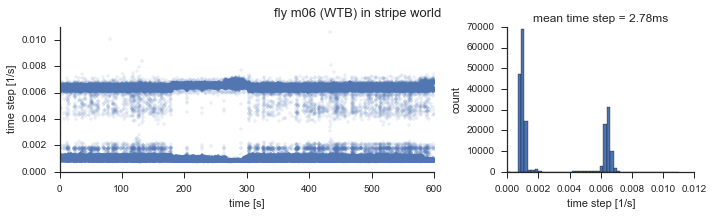

In [223]:
tstpfig = plt.figure(figsize = (10,3))
gs = gridspec.GridSpec(1,2,width_ratios=np.hstack((2,1)))
tstpfig.suptitle( titleString, fontsize = 13)

histRange = (0,0.011)

ax = tstpfig.add_subplot(gs[0])
ax.plot(FOData[0:-2,0],(FOData[1:-1,0]-FOData[0:-2,0]).astype('float'),'.', alpha = 0.1)
ax.set_ylim(histRange)
ax.set_xlim((0,time[-1]))
ax.set_xlabel('time [s]')
ax.set_ylabel('time step [1/s]')
myAxisTheme(ax)

ax = tstpfig.add_subplot(gs[1])
ax.hist(FOData[1:-1,0]-FOData[0:-2,0],50,histRange)
ax.set_xlabel('time step [1/s]')
ax.set_ylabel('count')
ax.set_title('mean time step = ' + str(round(np.mean((FOData[1:-1,0]-FOData[0:-2,0])*1000.0),2)) + 'ms' )
myAxisTheme(ax)

tstpfig.tight_layout()

try:
    mkdir(dataDir + 'analysis/timeStepPlot/')
except OSError:
    print('Plot directory already exists.')
    
tstpfig.savefig(dataDir + 'analysis/timeStepPlot/' + FODataFile[0:-4] + '_timeStepPlot.pdf', format = 'pdf')

####Plot velocity distributions of downsampled data

Plot directory already exists.


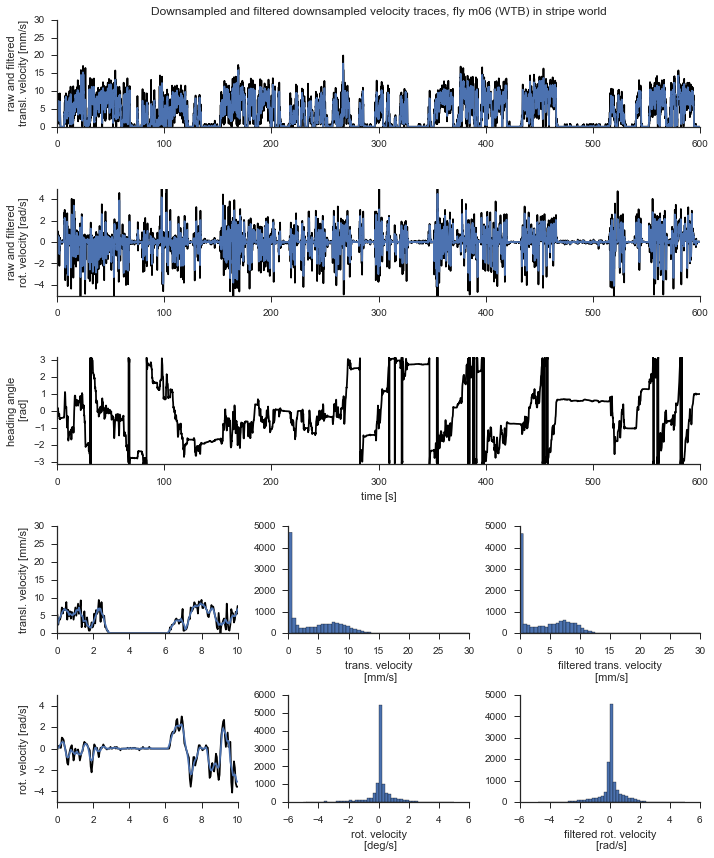

In [224]:
rotLim = (-5, 5)
transLim = (0, 30)
angleLim = (-np.pi, np.pi)
summaryVeloFig_ds = velocitySummaryPlot(time_ds, vTrans_ds, vTransFilt_ds, vRot_ds, vRotFilt_ds, angle_ds,
                                        rotLim, transLim, angleLim, 'Downsampled and filtered downsampled velocity traces, ' + titleString)

try:
    mkdir(dataDir + 'analysis/velocityTraces/')
except OSError:
    print('Plot directory already exists.')
    
summaryVeloFig_ds.savefig(dataDir + 'analysis/velocityTraces/' + FODataFile[0:-4] + '_veloTraces_ds.pdf', format = 'pdf')

#### Classify time point as 'moving' or 'non-moving' based on transl. velocity

In [225]:
vTransTH = 2.0
moving = vTrans_ds > vTransTH

#### Compute relative heading

In [226]:
if sceneType=='plane':
    objLocation = [0, 0]
    objDirection, objDistance, gammaFull, gamma, gammaV\
        = relationToObject(time_ds, xPosMA_ds, yPosMA_ds, angle_ds, objLocation)
else: #sceneType == 'stripe'
    gamma = abs(angle_ds)
    gammaFull = angle_ds

#### Heading angle distribution (if stripe)

Plot directory already exists.


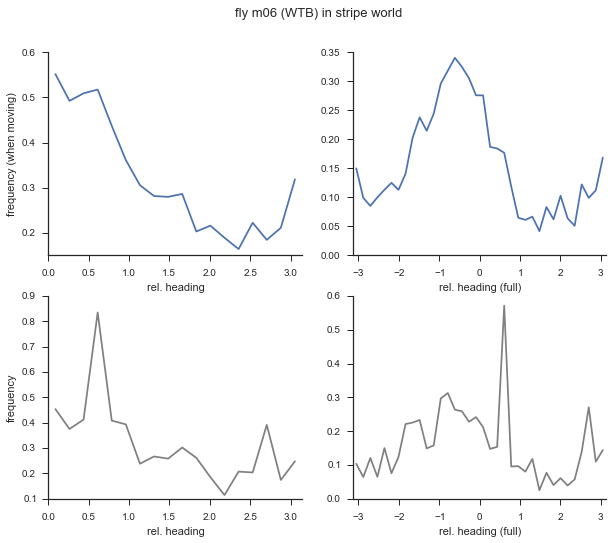

In [227]:
headingfig = plt.figure(figsize=(10,8))

gammaPlt = headingfig.add_subplot(221)
histRange = (0, np.pi)
nhead, edges = np.histogram(gamma[moving>0],density=True,range=histRange,bins=18)
gammaPlt.plot(edges[:-1]+np.diff(edges)/2,nhead)
gammaPlt.set_xlim(histRange)
gammaPlt.set_xlabel('rel. heading')
gammaPlt.set_ylabel('frequency (when moving)')
myAxisTheme(gammaPlt)

gammaFullPlt = headingfig.add_subplot(222)
histRange = (-np.pi, np.pi)
nhead, edges = np.histogram(gammaFull[moving>0],density=True,range=histRange,bins=36)
gammaFullPlt.plot(edges[:-1]+np.diff(edges)/2,nhead)
gammaFullPlt.set_xlim(histRange)
gammaFullPlt.set_xlabel('rel. heading (full)')
myAxisTheme(gammaFullPlt)

gammaPlt = headingfig.add_subplot(223)
histRange = (0, np.pi)
nhead, edges = np.histogram(gamma,density=True,range=histRange,bins=18)
gammaPlt.plot(edges[:-1]+np.diff(edges)/2,nhead,color='grey')
gammaPlt.set_xlim(histRange)
gammaPlt.set_xlabel('rel. heading')
gammaPlt.set_ylabel('frequency')
myAxisTheme(gammaPlt)

gammaFullPlt = headingfig.add_subplot(224)
histRange = (-np.pi, np.pi)
nhead, edges = np.histogram(gammaFull,density=True,range=histRange,bins=36)
gammaFullPlt.plot(edges[:-1]+np.diff(edges)/2,nhead,color='grey')
gammaFullPlt.set_xlim(histRange)
gammaFullPlt.set_xlabel('rel. heading (full)')
myAxisTheme(gammaFullPlt)


headingfig.suptitle(titleString,fontsize=13)

headingfig.tight_layout

try:
    mkdir(dataDir + 'analysis/heading/')
except OSError:
    print('Plot directory already exists.')
    
headingfig.savefig(dataDir + 'analysis/heading/' + FODataFile[0:-4] + '_headingDistribution.pdf', format = 'pdf')

### Stripe tracking trial....

### Walking in 2D plane trial.....

#### Plot trace and mark object locations

In [228]:
# (1) plot raw trace .........
if sceneType=='plane':
    tStart = 0
    tEnd = len(FOData[:,1])
    tStep = 72
    frameRange = range(tStart,tEnd,tStep)
    colMap = 'Accent' #'nipy_spectral'
    arrowLength = 5

    trajfig = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(2,1,height_ratios=np.hstack((10,1)))

    axTraj = trajfig.add_subplot(gs[0]) #trace plot
    axTime = trajfig.add_subplot(gs[1]) #time line

    plotPosInRange(axTraj,axTime,frameRange,FOData[:,0],FOData[:,1],FOData[:,2],np.pi/180*FOData[:,5],colMap,arrowLength,0.5,5)
    axTraj.scatter(visObjCoords[:,0],visObjCoords[:,1], 50, alpha=0.75,facecolor='black',edgecolors='none')
    axTraj.scatter(invisObjCoords[:,0],invisObjCoords[:,1], 50, alpha=0.5, facecolors='none', edgecolors='black') 
    axTraj.set_xlabel(header[1],fontsize=12)
    axTraj.set_ylabel(header[2],fontsize=12)  
    axTraj.set_title('Walking trace of ' + titleString)
    axTraj.set_xlim([min(FOData[:,1]) - 20, max(FOData[:,1]) + 20])
    axTraj.set_ylim([min(FOData[:,2]) - 20, max(FOData[:,2]) + 20])
    myAxisTheme(axTraj)

    axTime.set_xlabel(header[0],fontsize=12)  
    plt.xlim((0,FOData[-1,0]))
    timeAxisTheme(axTime)

    try:
        mkdir(dataDir + 'analysis/tracePlot/')
    except OSError:
        print('Plot directory already exists.')

    trajfig.savefig(dataDir + 'analysis/tracePlot/' + FODataFile[0:-4] + '_traceObjectPlot.pdf', format = 'pdf')

In [229]:
# (2) plot collapsed trace ........
if sceneType=='plane':
    tStart = 0
    tEnd = numFrames_ds
    tStep = 4
    frameRange = range(tStart,tEnd,tStep)
    colMap = 'Accent' #'nipy_spectral'
    arrowLength = 5

    colTrajFig = plt.figure(figsize=(9,10))
    gs = gridspec.GridSpec(2,1,height_ratios=np.hstack((10,1)))

    colTrajFig.suptitle('Collapsed walking trace ("mini arena" with central object)\n' + titleString, fontsize = 13)

    axTraj = colTrajFig.add_subplot(gs[0]) #trace plot
    axTime = colTrajFig.add_subplot(gs[1]) #time line
    plotPosInRange(axTraj,axTime,frameRange,time_ds,xPosMA_ds,yPosMA_ds,angle_ds,colMap,4,0.5,7)
    axTraj.plot(0,0,marker='o',markersize=20,linestyle='none',alpha=0.5,color='black')
    axTraj.set_xlabel(header[1],fontsize=12)
    axTraj.set_ylabel(header[2],fontsize=12)
    axTraj.set_ylim([-arenaRad -5,arenaRad + 5])
    axTraj.set_xlim([-arenaRad -5,arenaRad + 5])  
    myAxisTheme(axTraj)
    axTime.set_xlabel(header[0],fontsize=12)  
    plt.xlim((0,time_ds[-1]))
    timeAxisTheme(axTime)
    
    try:
        mkdir(dataDir + 'analysis/collapsedTracePlot/')
    except OSError:
        print('Plot directory already exists.')

    colTrajFig.savefig(dataDir + 'analysis/collapsedTracePlot/' + FODataFile[0:-4] + '_traceObjectPlot_ds.pdf', format = 'pdf')

### Save values for future analysis

In [230]:
if sceneType=='stripe':
    xPosMA_ds = np.nan*np.ones(np.size(time_ds))
    yPosMA_ds = np.nan*np.ones(np.size(time_ds))

toSave = {'time': time_ds,
          'xPos': xPos_ds,
          'yPos': yPos_ds,
          'xPosInMiniarena': xPosMA_ds,
          'yPosInMiniarena': yPosMA_ds,
          'headingAngle': angle_ds,
          'rotVelo': vRot_ds,
          'transVelo': vTrans_ds,
          'gammaFull': gammaFull,
          'gamma': gamma,
          'moving': moving}

np.save(expDir + FODataFile[:-4], toSave)
